# NLP CW Task 1

  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks
  - Your .README file should explain how to replicate the different experiments mentioned in your report

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from collections import Counter
import nltk
import string
import torchtext
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
import codecs
import tqdm
import re

In [2]:
# Get pretrained GloVe embeddings
glove = torchtext.vocab.GloVe(name='6B', dim=50)

# Install packages that Colab does not provide automatically
!pip -q install transformers
from transformers import RobertaTokenizer, RobertaModel, BertPreTrainedModel, DistilBertModel, DistilBertTokenizer

# Download stopwords
nltk.download('stopwords')

# Get test and train data files
if not os.path.exists('dev.csv'):
  !wget -q --show-progress https://raw.githubusercontent.com/matt-malarkey/nlp-cw-data/master/dev.csv
  !wget -q --show-progress https://raw.githubusercontent.com/matt-malarkey/nlp-cw-data/master/train.csv

.vector_cache/glove.6B.zip: 862MB [06:52, 2.09MB/s]                           
 99%|█████████▉| 397750/400000 [00:10<00:00, 36504.70it/s]

     |████████████████████████████████| 1.8MB 17.0MB/s 
     |████████████████████████████████| 890kB 56.1MB/s 
     |████████████████████████████████| 3.2MB 42.4MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
dev.csv             100%[===================>] 211.85K  --.-KB/s    in 0.008s  
train.csv           100%[===================>] 925.70K  --.-KB/s    in 0.03s   


In [3]:
# Setting random seed and device
SEED = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('dev.csv')

In [5]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

In [6]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
  """
  Training loop for the model, which calls on eval to evaluate after each epoch
  """

  print("Training model.")

  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(device)

  for epoch in range(1, number_epoch+1):
    model.train()

    epoch_loss = 0
    epoch_sse = 0
    no_observations = 0  # Observations used for training so far

    for batch in train_iter:
      ids = batch['ids'].to(device).squeeze()
      mask = batch['mask'].to(device).squeeze()
      target = batch['target'].to(device, dtype=torch.float)
      extra_features = batch['extra_features'].to(device)

      predictions = model(ids, mask, extra_features).squeeze(1)
      optimizer.zero_grad()
      loss = loss_fn(predictions, target)

      no_observations = no_observations + target.shape[0]
      sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse

    valid_loss, valid_mse, __, __ = eval(dev_iter, model)

    epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
    print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
    Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [7]:
# We evaluate performance on our dev set
def eval(data_iter, model):
  """
  Evaluating model performance on the dev set
  """
  model.eval()
  epoch_loss = 0
  epoch_sse = 0
  pred_all = []
  trg_all = []
  no_observations = 0
  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(device)

  with torch.no_grad():
    for batch in data_iter:
      ids = batch['ids'].to(device).squeeze()
      mask = batch['mask'].to(device).squeeze()
      target = batch['target'].to(device, dtype=torch.float)
      extra_features = batch['extra_features'].to(device)

      predictions = model(ids, mask, extra_features).squeeze(1)

      loss = loss_fn(predictions, target)

      # We get the mse
      pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
      sse, __ = model_performance(pred, trg)

      no_observations = no_observations + target.shape[0]
      epoch_loss += loss.item()*target.shape[0]
      epoch_sse += sse
      pred_all.extend(pred)
      trg_all.extend(trg)

  return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [8]:
# How we print the model performance
def model_performance(output, target, print_output=False):
  """
  Returns SSE and MSE per batch (printing the MSE and the RMSE)
  """
  sq_error = (output - target)**2

  sse = np.sum(sq_error)
  mse = np.mean(sq_error)
  rmse = np.sqrt(mse)

  if print_output:
    print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

  return sse, mse

# Data Analysis


Number of Headlines: 9652, Max Headline Length: 146, Avg Score: 0.94
Most common words: [('Trump', 3320), ('The', 557), ('House', 488), ('says', 483), ('Donald', 356)]
Headlines with Trump: 39.11%, Avg Score: 1.02
Proportion of Trump Headlines with score > 1: 42.38%


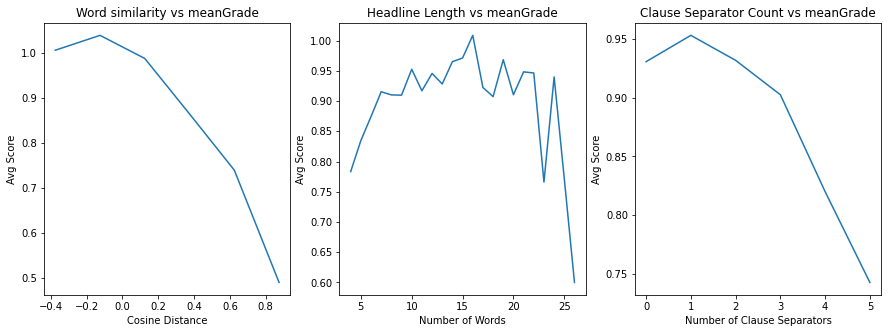

In [9]:
# Basic Stats
num_headlines = len(train_df)
max_len = max(train_df['original'].apply(len))
avg_score = train_df['meanGrade'].mean()
print(f'Number of Headlines: {num_headlines}, Max Headline Length: {max_len}, Avg Score: {avg_score:.2f}')

# Most common words
stopwords = nltk.corpus.stopwords.words('english')
most_common_words = Counter(" ".join(train_df['original']).split()).most_common(100)
stopwords.append(string.punctuation)
most_common_words = [(word, count) for (word, count) in most_common_words if word not in stopwords and word.isalpha()][:5]
print(f'Most common words: {most_common_words}')

# Analysis of Trump Headlines
trump_headlines = train_df[train_df['original'].str.lower().str.contains('trump')]
num_headlines_with_trump = len(trump_headlines)
trump_avg_score = trump_headlines['meanGrade'].mean()
prob_headline_contains_trump = num_headlines_with_trump / num_headlines
trump_value_counts = trump_headlines['meanGrade'].value_counts(bins=3)
trump_proportion_gt_one = (trump_value_counts[2] + trump_value_counts[3]) * 100 / num_headlines_with_trump
print(f'Headlines with Trump: {prob_headline_contains_trump * 100:.2f}%, Avg Score: {trump_avg_score:.2f}')
print(f'Proportion of Trump Headlines with score > 1: {trump_proportion_gt_one:.2f}%')

# Analysis of word similarity and length of headlines
similarity_data = []
headline_length_data = []
for row in train_df.itertuples():
  headline_length_data.append((len(row.original.split(' ')), row.meanGrade))
  for word in row.original.split(' '):
    if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
      original_word_vec = glove[word[1:-2].lower()].unsqueeze(0)
      edited_word_vec = glove[row.edit.lower()].unsqueeze(0)
      distance = torch.cosine_similarity(original_word_vec, edited_word_vec).item() 
      similarity_data.append((distance, row.meanGrade))

# Analysis of # of clause separators
separators_data = []
for i in range(len(train_df['original'])):
  matches = re.findall("[;,:(...)]", train_df['original'][i])
  separators_data.append((len(matches), train_df['meanGrade'][i]))

# Plot word similarity vs meanGrade
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
mean_stat_similarity = binned_statistic(*zip(*similarity_data), bins=6, range=(-0.5, 1.0))
plt.plot(mean_stat_similarity.bin_edges[:-1] + 0.125, mean_stat_similarity.statistic)
plt.xlabel('Cosine Distance')
plt.ylabel('Avg Score')
plt.title('Word similarity vs meanGrade')

# Plot headline length vs meanGrade
plt.subplot(1, 3, 2)
mean_stat_headline_len = binned_statistic(*zip(*headline_length_data), bins=30, range=(0, 30))
plt.plot(mean_stat_headline_len.bin_edges[:-1], mean_stat_headline_len.statistic)
plt.xlabel('Number of Words')
plt.ylabel('Avg Score')
plt.title('Headline Length vs meanGrade')


# Plot clause separator count vs meanGrade
plt.subplot(1, 3, 3)
plt.plot()
mean_stat_seps = binned_statistic(*zip(*separators_data), bins=6)
plt.plot(mean_stat_seps.bin_edges[:-1], mean_stat_seps.statistic)
plt.xlabel('Number of Clause Separators')
plt.ylabel('Avg Score')
plt.title('Clause Separator Count vs meanGrade')

plt.show()

## Preprocessing

In [10]:
# Pattern to match words and multiword tags
# See https://regex101.com/r/a2cWZL/1 for example
# TOKEN_PATTERN = re.compile("[A-Za-z#]+|<[A-Za-z#]+\s[A-Za-z]+\/>")

# Patten to match only words
TOKEN_PATTERN = re.compile("\w+")
CLAUSE_SEPS = re.compile("[;,:(...)]")

# TODO: processing of:
# - hashtags,
# - words with a "-" in between them
# - punctuation
# - entity names

def tokenize(sentence):
  return TOKEN_PATTERN.findall(sentence)

# Remove angle brackets and lowercase
def preprocess(word):
  if len(word) > 2 and word[0] == '<' and word[-2] == '/' and word[-1] == '>' :
    word = word[1:-2]
  return word.lower()

def create_vocab(data):
  """
  Creating a corpus of all the tokens used
  """
  # Let us put the tokenized corpus in a list
  tokenized_corpus = [[preprocess(t) for t in tokenize(s)] for s in data]

  # Create single list of all vocabulary
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
      if token not in vocabulary:
        vocabulary.append(token)

  return vocabulary, tokenized_corpus

# Extra features:
# [0] - binary if 'Trump' in headline
# [1] - length of headline          <--- will passing as a feature help bc all headlines are padded?
# [3] - number of clause separators: elipsis, commas, colons or semi colons
# other features: avg word length?
EXTRA_FEATURES = 3
def extract_features(raw_headline):
  return [
    int('Trump' in raw_headline), 
    len(raw_headline),
    len(CLAUSE_SEPS.findall(raw_headline))
  ]

In [11]:
# Inherits from Dataset class so the DataLoader can use it
class Task1Dataset(Dataset):

  def __init__(self, tokenizer, train_data, labels):
    self.x_train = train_data
    self.y_train = labels
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, item):
    # Preprocess headline before embedding
    headline = self.x_train[item]
    # processed_headline = ' '.join([preprocess(t) for t in tokenize(headline)])
    processed_headline = [preprocess(t) for t in tokenize(headline)]

    target = self.y_train[item]

    # Use is_split_into_words=True to allow for our own tokenizing
    # - stops encode_plus splitting up unknown words into multiple parts
    encoding = self.tokenizer.encode_plus(processed_headline, return_tensors='pt',
                                          padding='max_length', truncation=True,
                                          max_length=128, pad_to_max_length=True,
                                          is_split_into_words=True)
    ids = encoding['input_ids']
    mask = encoding['attention_mask']

    extra_features = extract_features(headline)

    return {
      'ids': torch.tensor(ids),
      'mask': torch.tensor(mask),
      'target': torch.tensor(target),
      'extra_features': torch.tensor(extra_features)
    }

In [12]:
class BertRegressionModel(nn.Module):
  def __init__(self):
    super(BertRegressionModel, self).__init__()

    self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
    # self.bert = RobertaModel.from_pretrained('roberta-base')
    self.num_extra_features = EXTRA_FEATURES
    self.linear1 = nn.Linear(768, 32)
    self.linear2 = nn.Linear(32 + self.num_extra_features, 1)

  def forward(self, ids, mask, extra_features):
    embeddings = self.bert(input_ids=ids, attention_mask=mask)[0]
    x = self.linear1(embeddings[:, 0])
    concat_features = torch.cat([x, extra_features], dim=1)
    x = self.linear2(concat_features)
    return x

### Approach 1: Usiung pre-trained representations

In [13]:
BATCH_SIZE = 32

# Initialise chosen BERT model and tokenizer
# To change the model to use Roberta, uncomment the bert model in the cell above
# and uncomment the tokenizer below.
model = BertRegressionModel().to(device)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set training and test data
training_data = train_df['original']
training_labels = train_df['meanGrade']
test_data = test_df['original']
train_and_dev = Task1Dataset(tokenizer, training_data, training_labels)

# Split training data into train and dev sets
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev, (train_examples, dev_examples))

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE)

 99%|█████████▉| 397750/400000 [00:30<00:00, 36504.70it/s]


womensmarch against donald trump around the world
['women', '##sma', '##rch', 'against', 'donald', 'trump', 'around', 'the', 'world']
disappeared lawyer investigating in egypt the death of cambridge student giulio regeni re appears in court under charges
['disappeared', 'lawyer', 'investigating', 'in', 'egypt', 'the', 'death', 'of', 'cambridge', 'student', 'gi', '##ulio', 'reg', '##eni', 're', 'appears', 'in', 'court', 'under', 'charges']
this is not the end john mccain warns trump torches rand paul on syria missile strikes
['this', 'is', 'not', 'the', 'end', 'john', 'mccain', 'warns', 'trump', 'torches', 'rand', 'paul', 'on', 'syria', 'missile', 'strikes']


In [ ]:
# Do the training
optimizer = torch.optim.Adam(model.parameters())
train(train_loader, dev_loader, model, epochs)

### Aside: Using NER for Feature Engineering

In [43]:
import spacy

stop_words = nltk.corpus.stopwords.words("english")

# spacy
nlp = spacy.load("en_core_web_sm")

# ps = nltk.stem.porter.PorterStemmer()
# print([ps.stem(word) for word in txt])

# lem = nltk.stem.wordnet.WordNetLemmatizer()
# print([lem.lemmatize(word) for word in txt])

# Test sentences
sents = [
  "#WomensMarch against <Donald Trump/> around the world",
  "' Disappeared ' Lawyer investigating in Egypt the death of Cambridge student , Giulio Regeni , re-appears in court , under <charges/> ",
  "' This is not the end ' : <John McCain/> warns Trump , torches Rand Paul on Syria missile strikes"
]

# Map entities to an index, for representing as 1HV
entities = []

# Build model
for s in sents:
  pre_s = ' '.join([preprocess(t) for t in tokenize(s)])
  r_sub = re.sub(r'[^\w\s]', '', str(s))

  print()
  print(f"Original:       {s}")
  print(f"Preprocessed:   {pre_s}")
  print(f"New regex:      {r_sub}")
  print(f"BERT Tokenized: {tokenizer.tokenize(pre_s)}")

  # NER
  doc = ner(r_sub)
  spacy.displacy.render(doc, style="ent", jupyter=True)

  # TODO: try and merge 'Trump' and 'Donald Trump' for PERSON entities
  for e in doc.ents:
    if e not in entities:
        entities.append(e)

  print()
  
ent2idx = {e: idx for (idx, e) in enumerate(entities)}
print(ent2idx)


Original:       #WomensMarch against <Donald Trump/> around the world
Preprocessed:   womensmarch against donald trump around the world
New regex:      WomensMarch against Donald Trump around the world
BERT Tokenized: ['women', '##sma', '##rch', 'against', 'donald', 'trump', 'around', 'the', 'world']




Original:       ' Disappeared ' Lawyer investigating in Egypt the death of Cambridge student , Giulio Regeni , re-appears in court , under <charges/> 
Preprocessed:   disappeared lawyer investigating in egypt the death of cambridge student giulio regeni re appears in court under charges
New regex:       Disappeared  Lawyer investigating in Egypt the death of Cambridge student  Giulio Regeni  reappears in court  under charges 
BERT Tokenized: ['disappeared', 'lawyer', 'investigating', 'in', 'egypt', 'the', 'death', 'of', 'cambridge', 'student', 'gi', '##ulio', 'reg', '##eni', 're', 'appears', 'in', 'court', 'under', 'charges']




Original:       ' This is not the end ' : <John McCain/> warns Trump , torches Rand Paul on Syria missile strikes
Preprocessed:   this is not the end john mccain warns trump torches rand paul on syria missile strikes
New regex:       This is not the end   John McCain warns Trump  torches Rand Paul on Syria missile strikes
BERT Tokenized: ['this', 'is', 'not', 'the', 'end', 'john', 'mccain', 'warns', 'trump', 'torches', 'rand', 'paul', 'on', 'syria', 'missile', 'strikes']



{Donald Trump: 0, Lawyer: 1, Egypt: 2, Cambridge: 3, Giulio Regeni: 4, John McCain: 5, Trump: 6, Rand Paul: 7, Syria: 8}


### Approach 2: No pre-trained representations

In [42]:
# TODO:
# - remove stop words
# - different norms
# - pre: weigh query terms higher for certain

train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)